In [1]:
from convexness.convexness import *
import glob
import os
import open3d as o3d
import pandas as pd
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
n_random_samples = 800
min_fragments = 3
max_fragments = 8
num_points = 10000

In [8]:
def process_our_folder(folder):
    target_extension = '.stl'
    metadata_pattern = '*_mesh.txt'
    path = folder + '*/' + metadata_pattern
    mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)
    
    #
    global_df = None
    
    for metadata_file in mesh_files:
        df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
        
        # maintain only a subset of the columns
        df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
        if global_df is None:
            global_df = df
        else:
            global_df = pd.concat([global_df, df], ignore_index=True)
            
    # filter files by target extension
    global_df = global_df[global_df['Filename'].str.contains(target_extension)]
            
    # create a new column with the number of fragments
    global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))
    # select n random samples
    global_df = global_df[max_fragments >= global_df['Fragments']]  
    global_df = global_df[min_fragments <= global_df['Fragments']]
    
    print('Number of fragments:', global_df.shape[0])
    
    global_df = global_df.sample(n=n_random_samples)

    # iterate to calculate the convexness
    for index, row in tqdm(global_df.iterrows(), total=global_df.shape[0]):
        filename = row['Filename']
        filename = filename.replace('E:/Fragments/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/')
        
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    return global_df

In [9]:
def process_voronoi_folder(folder):
    target_extension = '.obj'
    files = glob.glob(folder + '*/*' + target_extension, recursive=True)
    # get number of fragments as the first number in the filename before '_'
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    for file in files:
        file_name = os.path.basename(file)
        fragments = int(file_name.split('_')[0])
        global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [fragments]})], ignore_index=True)
        
    # filter by the number of fragments
    global_df = global_df[max_fragments >= global_df['Fragments']]
    global_df = global_df[min_fragments <= global_df['Fragments']] 
    
    # random sampling
    print('Number of fragments:', global_df.shape[0])
    random_rows = global_df.sample(n=n_random_samples)
    for index, row in random_rows.iterrows():
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [10]:
def process_sellan_folder(folder):
    # find subfolders
    subfolders = glob.glob(folder + '*/*/')
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    
    for subfolder in subfolders:
        # find obj inside the subfolder
        files = glob.glob(subfolder + '*.obj')
        n_fragments = len(files)
        
        if min_fragments<= n_fragments <= max_fragments:          
            for file in files:
                global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [n_fragments]})], ignore_index=True)
            
    print('Number of fragments:', global_df.shape[0])
            
    # read the mesh
    random_rows = global_df.sample(n=n_random_samples)
    for index, row in random_rows.iterrows():
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [ ]:
#folders = ['D:/allopezr/Fragments/Vessels_200_Voronoi/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/']

folders = ['D:/allopezr/Fragments/Artifacts_200_CellFracture/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl/', 'D:/allopezr/Datasets/BreakingBad/artifact/']

#folders = ['D:/allopezr/Datasets/BreakingBad/artifact_compressed/']
results = []

for folder in tqdm(folders):
    print(folder)
    
    if 'CellFracture' in folder:
        global_df = process_voronoi_folder(folder)
    elif 'BreakingBad' in folder:
        global_df = process_sellan_folder(folder)
    else:
        global_df = process_our_folder(folder) 
        
    results.append(global_df[['Fragments', 'Convexness']])

  0%|          | 0/3 [00:00<?, ?it/s]

D:/allopezr/Fragments/Artifacts_200_CellFracture/
Number of fragments: 812


In [7]:
results_copy = results.copy()

In [ ]:
# calculate only for sellan
global_df = process_sellan_folder('D:/allopezr/Datasets/BreakingBad/artifact/')

In [ ]:
# substitute this result with the previous one
results[2] = global_df[['Fragments', 'Convexness']]

In [8]:
import matplotlib.pyplot as plt

# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 19}
plt.rc('font', **font_mapping)

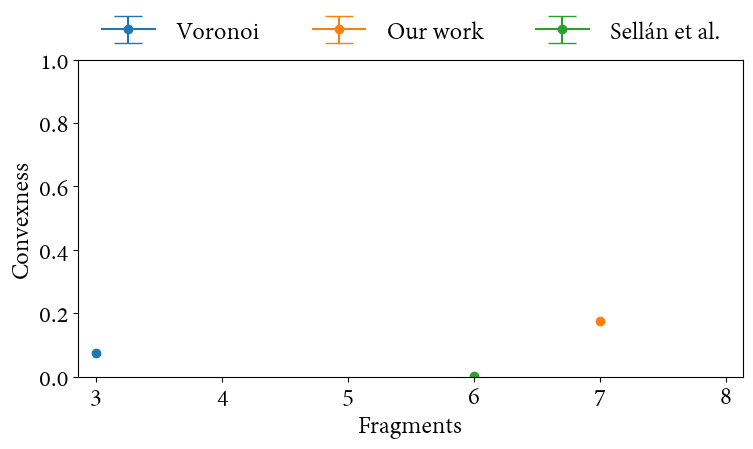

In [9]:
# render the results
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work', 'Sellán et al.']

plt.figure(figsize=(8, 5))

# average convexness per number of fragments
for idx, (df, legend) in enumerate(zip(results, legends)):  
    df = df.dropna()
    mean = df.groupby('Fragments').mean()
    std = df.groupby('Fragments').std()  
    
    # box plot
    plt.errorbar(mean.index, mean['Convexness'], yerr=std['Convexness'], fmt='o-', label=legend, capsize=10)
    
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.xlabel('Fragments')
plt.ylabel('Convexness')
plt.xlim(3 - 0.14, max_fragments + 0.14)
plt.ylim(.0, 1.0)
plt.tight_layout()
plt.savefig('convexness.png', dpi=300)
plt.show()

In [ ]:
# percentil 75, 50, 25
for df in results:
    print(df['Convexness'].quantile([0.25, 0.5, 0.75]))